In [1]:
''' Code from Haodong Qin
edited by Iulia Rusu 
'''

import sys, os #, re, glob, socket, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





In [2]:
#import sci-kit learn for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

### 1: Functions needed for geodesic projection

In [3]:
def Mobius_addition(x,y,c):

    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space

    top = (1 + 2*c* np.dot(x,y) + c* np.dot(y,y))*x + (1-c*np.dot(x,x))*y
    bottom = 1 + 2*c* np.dot(x,y) + c**2*np.dot(x,x)*np.dot(y,y)
    return top/bottom


def Mobius_scalarMulti(x,r,c):

    # scalar vector multiplication
    # x is a N-dim vector, c is the curvature of the hyperbolic space

    result = 1/np.sqrt(c)*np.tanh(r*np.arctanh(np.sqrt( c*np.dot(x,x) ))) * x/np.sqrt(np.dot(x,x))
    return result 


def Geodesic_distance(x,y,c):
    
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space
    direc_vector = Mobius_addition(-x,y,c)
    dist = 2/np.sqrt(c)*np.arctanh(np.sqrt(c * np.dot(direc_vector,direc_vector) ))

    return dist

def Geodesic_r(t,x,y,c):

    # find the position vector on the geodesic connecting two vectors x and y 
    # when t = 0, final_position = x
    # when t = 1, final_position = y
    direc_vector = Mobius_addition(-x,y,c)

    displace_vector = Mobius_scalarMulti(direc_vector,t,c)

    final_position = Mobius_addition(x,displace_vector,c)

    return final_position

def Geodesic_projection_OptFun(t,x,y,c,p):
    # Function that is needed to optimized to find the geometric projection t
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # geodesic is connecting x and y
    # p is some vector 

    r_geodesic = Geodesic_r(t,x,y,c)

    dist = Geodesic_distance(p,r_geodesic,c)

    return dist


def conformal_factor(x,c):
    # deformation of the mapping from linear to hyperbolic space at position x

    lambda_c_x = 2/(1-c*np.dot(x,x))
    return lambda_c_x

def logarithmic_map(x,y,c):

    # the logarithmic_map will map a position vector y onto the tangent space at x in a hyperbolic space with curvature c
    # logarithmic_map: position in hyperbolic space -> tangent vector in tangent space
    
    minus_x_plus_y = Mobius_addition(-x,y,c)

    length_minus_x_plus_y = np.sqrt(np.dot(minus_x_plus_y,minus_x_plus_y))

    prefactor = 2/np.sqrt(c)/conformal_factor(x,c)*np.arctanh(np.sqrt(c)*length_minus_x_plus_y) 

    tangent_vector = prefactor*minus_x_plus_y/length_minus_x_plus_y

    return tangent_vector

def exponential_map(x,v,c):

    # the exponential_map will map a tangent vector v in the tangent space at x to a position vector in hyperbolic space with curvature c
    # exponential_map: tangent vector in tangent space -> position in hyperbolic space

    # first mapping the tangent vector v in linear space to vector in hyperbolic space
    length_v = np.sqrt(np.dot(v,v))
    constant_1 = np.sqrt(c)*conformal_factor(x,c)*length_v/2
    v_hyp = np.tanh(constant_1)*v/length_v/np.sqrt(c)

    # position vector in hyperbolic space:
    position_vector = Mobius_addition(x,v_hyp,c)

    return position_vector


    

### 3: doing the geometric projection

In [4]:
def hyp_to_hyp_poincare(hyp):

    t = 1
    for coord_idx in hyp.columns:

        t = t + hyp[coord_idx]**2

    t = np.sqrt(t)

    hyp_geo = hyp.copy()

    for coord_idx in hyp_geo.columns:

        hyp_geo[coord_idx] =  hyp_geo[coord_idx]/(1+t)

    return hyp_geo


In [5]:
#access hyp_emb from different notebook
%store -r ON_OFF_pcoords 

In [6]:
ON_OFF_pcoords.shape

(76, 6)

In [7]:
#  import your data as dataframe, make sure the columns only include coordinates in the hyperbolic space
df_data = pd.DataFrame(ON_OFF_pcoords)

# select the point where the tangent space is located, usually at the origin
reference_point_tangent_space =  np.zeros(df_data.shape[1])

In [8]:
#origin in N dimensional space
reference_point_tangent_space

array([0., 0., 0., 0., 0., 0.])

In [9]:
# transform the coordinates from native to Poincare ball
hyp_poincare = hyp_to_hyp_poincare(df_data)

# constant, this is fixed, no change
c_hyperbolicSpace = 1

# calculate the tangent vector using logrithmic map
hyp_tangent = hyp_poincare.copy()

for i in range(hyp_poincare.shape[0]):
    current_position_hyp = np.squeeze(hyp_tangent.values[i])
    hyp_tangent.iloc[i] = logarithmic_map(reference_point_tangent_space,current_position_hyp,c_hyperbolicSpace)


In [10]:
hyp_tangent


,0,1,2,3,4,5
0,0.036252,0.001181,0.056611,0.186477,-0.149912,-0.286575
1,0.026184,-0.010288,0.024054,0.149078,-0.205541,-0.276819
2,0.007351,-0.075785,-0.010468,0.213372,-0.169996,-0.252969
3,0.041380,0.009366,0.058785,0.189746,-0.138338,-0.290351
4,0.185478,-0.041317,-0.045399,0.140915,-0.150451,-0.258005
...,...,...,...,...,...,...
71,0.065112,0.004547,-0.274997,0.097826,0.209565,0.095660
72,0.018151,-0.089762,-0.022971,0.021024,0.293352,0.189070
73,-0.254786,0.081875,-0.143803,-0.082571,-0.202958,-0.055161
74,-0.258468,0.082743,-0.093786,-0.230679,-0.097347,-0.066349


In [11]:
%store -r ON_OFF_labels 

In [12]:
hyp_tangent['identity'] = ON_OFF_labels 

In [13]:
hyp_tangent

,0,1,2,3,4,5,identity
0,0.036252,0.001181,0.056611,0.186477,-0.149912,-0.286575,ON
1,0.026184,-0.010288,0.024054,0.149078,-0.205541,-0.276819,ON
2,0.007351,-0.075785,-0.010468,0.213372,-0.169996,-0.252969,ON
3,0.041380,0.009366,0.058785,0.189746,-0.138338,-0.290351,ON
4,0.185478,-0.041317,-0.045399,0.140915,-0.150451,-0.258005,ON
...,...,...,...,...,...,...,...
71,0.065112,0.004547,-0.274997,0.097826,0.209565,0.095660,OFF
72,0.018151,-0.089762,-0.022971,0.021024,0.293352,0.189070,OFF
73,-0.254786,0.081875,-0.143803,-0.082571,-0.202958,-0.055161,OFF
74,-0.258468,0.082743,-0.093786,-0.230679,-0.097347,-0.066349,OFF


In [14]:
data = hyp_tangent

In [18]:
data[data['identity'] == 'ON'].iloc[:, 0:6].head()

,0,1,2,3,4,5
0,0.036252,0.001181,0.056611,0.186477,-0.149912,-0.286575
1,0.026184,-0.010288,0.024054,0.149078,-0.205541,-0.276819
2,0.007351,-0.075785,-0.010468,0.213372,-0.169996,-0.252969
3,0.041380,0.009366,0.058785,0.189746,-0.138338,-0.290351
4,0.185478,-0.041317,-0.045399,0.140915,-0.150451,-0.258005


In [19]:
# ON_means= np.mean(data.values[0:29, :], axis = 0)
#caluclate means across the column
#digit at the end of the array listed in exclusive, so actually 0 :5 index

ON_means = data[data['identity'] == 'ON'].iloc[:, 0:6].mean(axis=0)

In [20]:
ON_means = np.array(ON_means)

In [21]:
OFF_means = data[data['identity'] == 'OFF'].iloc[:, 0:6].mean(axis=0)

In [22]:
OFF_means = np.array(OFF_means)

In [23]:
#subtract ON from OFF
diff_means = ON_means[0:6] - OFF_means[0:6]

In [24]:
#normalize the difference
normalized = diff_means/np.linalg.norm(diff_means)

In [25]:
normalized

array([ 0.64967646, -0.53129615,  0.47057615,  0.00152187, -0.12380501,
       -0.24263755])

In [26]:
axis_trans = np.dot(data.values[:, 0:6], normalized)

In [27]:
axis_trans.shape

(76,)

In [28]:
clust_labs_reshaped = ON_OFF_labels[:, np.newaxis]
clust_labs_reshaped.shape

(76, 1)

In [29]:
axis_trans_reshaped = axis_trans[:, np.newaxis]

In [31]:
combined_array = np.concatenate((axis_trans_reshaped, clust_labs_reshaped), axis=1)

In [32]:
axis_trans_df = pd.DataFrame(combined_array)

In [33]:
axis_trans_df

,0,1
0,0.137942,ON
1,0.126637,ON
2,0.122865,ON
3,0.137436,ON
4,0.202531,ON
...,...,...
71,-0.138528,OFF
72,-0.033489,OFF
73,-0.238314,OFF
74,-0.228215,OFF


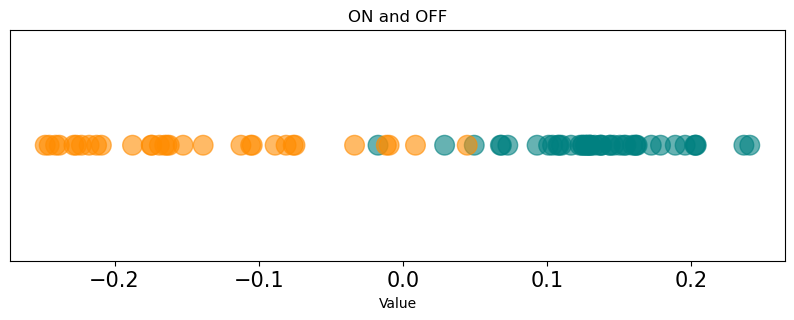

In [54]:
axis_trans_df.columns = ['Value', 'Category']


color_map = {'ON': 'teal',  'OFF': 'darkorange'}

# Map labels to colors using the color map
label_colors = axis_trans_df['Category'].map(color_map)

# Create scatter plot with specified figure size
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(axis_trans_df['Value'], [0] * len(axis_trans_df), c=label_colors, s=200, alpha = 0.6)
ax.set_xlabel('Value')
plt.xticks(fontsize=15 ) #rotation=90 
ax.yaxis.set_visible(False)

ax.set_title('ON and OFF')

plt.show()

# plt.savefig('final_images/ON_OFF_tangent.png', dpi=300, bbox_inches='tight', format='png')



In [63]:
axis_trans_df

,Value,Category
0,0.093545,AVA
1,0.089763,AVA
2,-0.016134,AVA
3,0.139165,AVA
4,0.107323,AVA
...,...,...
64,0.17609,RME
65,0.148105,RME
66,0.26241,RME
67,0.218891,RME


In [64]:
RME = axis_trans_df[axis_trans_df['Category'] == 'RME']['Value']
AVA = axis_trans_df[axis_trans_df['Category'] == 'AVA']['Value']





(array([[0., 0., 0., 0., 0., 0., 1., 5., 2., 0., 2., 0., 2., 5., 5., 2.,
         1., 2., 2., 1.],
        [9., 2., 2., 0., 2., 8., 2., 4., 2., 0., 1., 1., 2., 1., 1., 2.,
         0., 0., 0., 0.]]),
 array([-0.22002025, -0.19589873, -0.17177722, -0.14765571, -0.1235342 ,
        -0.09941268, -0.07529117, -0.05116966, -0.02704815, -0.00292663,
         0.02119488,  0.04531639,  0.0694379 ,  0.09355941,  0.11768093,
         0.14180244,  0.16592395,  0.19004546,  0.21416698,  0.23828849,
         0.26241   ]),
 <a list of 2 list[Polygon] objects>)

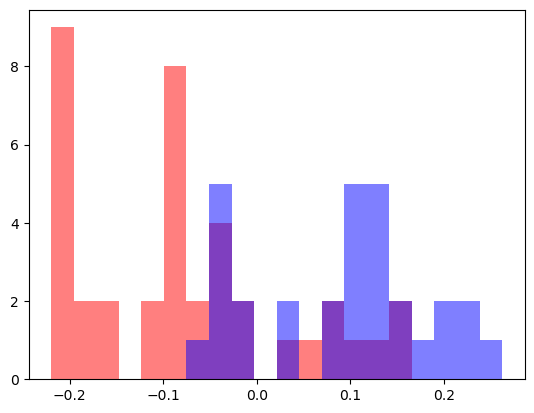

In [66]:
plt.hist([RME, AVA], bins = 20, alpha=0.5, label=['RME', 'AVA'], color = [ 'blue','red'], histtype='stepfilled')


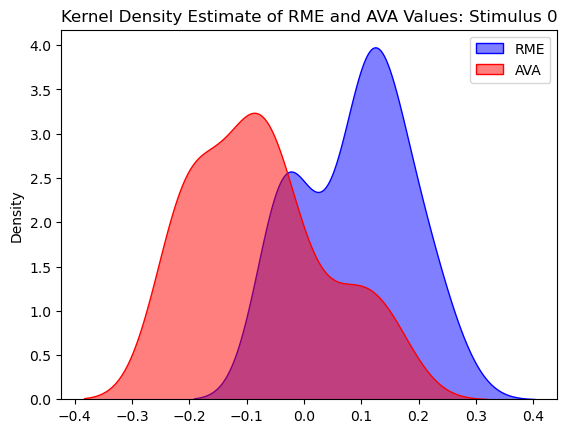

In [67]:
# Plotting KDE for each category
sns.kdeplot(RME, color='blue', fill=True, alpha=0.5, label='RME')
sns.kdeplot(AVA, color='red', fill=True, alpha=0.5, label='AVA')

# Adding labels and title
plt.xlabel('')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of RME and AVA Values: Stimulus 0')
plt.legend()

# Show the plot
plt.show()

#what should the x-axis be?

In [ ]:
#look at distance between distributions, KS distance 

In [136]:
#use svm in 8 dim space 
#also try a logistic regression, using 8 dim tangent space data and correspoding labels
#try MNE on tangent space coords
y = data.iloc[:, -1]
X = data.iloc[:, 0:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [138]:
logreg = LogisticRegression(random_state=16)

# Train the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [139]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [140]:
y_pred = logreg.predict(X_test)

In [141]:
y_pred

array(['RME', 'RME', 'AVA', 'RME', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA',
       'AVA', 'AVA', 'AVA', 'RME', 'AVA', 'RME'], dtype=object)

In [143]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4, 1],
       [6, 4]])

NameError: name 'Text' is not defined

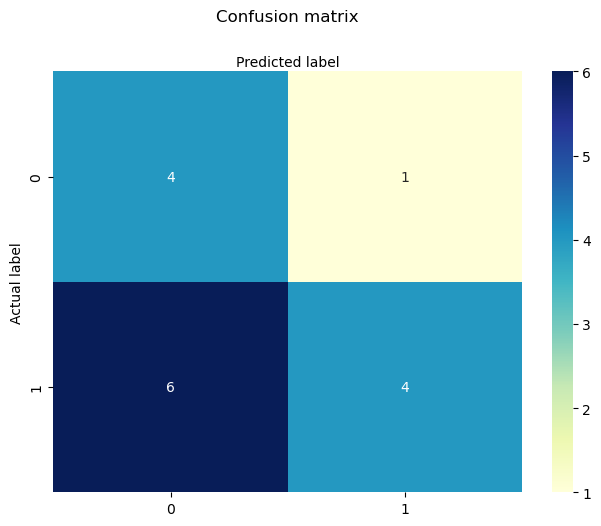

In [144]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label');

In [149]:
target_names = ['AVA', 'RME']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         AVA       0.40      0.80      0.53         5
         RME       0.80      0.40      0.53        10

    accuracy                           0.53        15
   macro avg       0.60      0.60      0.53        15
weighted avg       0.67      0.53      0.53        15

